In [90]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree

# log returns data
log_rets = pd.read_csv('returns_clean.csv', index_col = 'timestamp', parse_dates = ['timestamp'])

# import distance matrix
with open('dtw_standardized.npy', 'rb') as matrix:
    dist_mat = np.load(matrix)
    
# input for the MST
X = csr_matrix(dist_mat)

# turn into an MST
graph = minimum_spanning_tree(X).toarray()

In [52]:
# process into source / target data
coin_names = [col.split('_')[0] for col in log_rets.columns]

# convert to df
graph_df   = pd.DataFrame(graph, columns = coin_names, index = coin_names)

# melt to re-organize into source / target dichotomy
graph_data = graph_df.melt(ignore_index = False).reset_index()

# rename for clarity
graph_data.rename({'index': 'Source', 'variable': 'Target', 'value': 'Weight'},
                  axis = 1, inplace = True)

# remove redundant pairs w/ same Source - Target values (ie, bitcoin to bitcoin)
query = graph_data.Source != graph_data.Target
graph_data = graph_data.loc[query, :]

# initial dataset
graph_data.head()

,Source,Target,Weight
1,ethereum,bitcoin,324.385698
2,tether,bitcoin,0.000000
3,binance-coin,bitcoin,0.000000
4,usd-coin,bitcoin,0.000000
5,ripple,bitcoin,0.000000


In [54]:
# export this to use for visualization
graph_data.to_csv('dtw_graph.csv', index = False)

This next block of code will now create similar code, but for a correlation matrix, instead of a dtw matrix.

In [89]:
# standardize log_returns
log_means = log_rets.mean(axis = 0)
log_stds  = log_rets.std(axis = 0)

rets_copy = log_rets.copy(deep = True)

rets_copy -= log_means
rets_copy /= log_stds

# create correlation matrix
log_corr = rets_copy.corr()

# convert to a distance matrix
corr_mat = np.sqrt(2 * (1 - log_corr))

# turn into an MST
graph2 = minimum_spanning_tree(csr_matrix(corr_mat)).toarray()

# convert to Source / Target / Weight format -- same code as above
graph_df2   = pd.DataFrame(graph2, columns = coin_names, index = coin_names)
graph_data2 = graph_df2.melt(ignore_index = False).reset_index()
graph_data2.rename({'index': 'Source', 'variable': 'Target', 'value': 'Weight'},
                  axis = 1, inplace = True)

query       = graph_data2.Source != graph_data2.Target
graph_data2 = graph_data2.loc[query, :]

# export to csv
graph_data2.to_csv('corr_graph.csv', index = False)

We'll now visualize each, to compare the two.

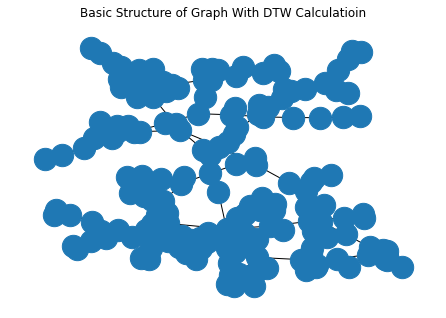

In [105]:
def make_label_dict(labels):
    l = {}
    for i, label in enumerate(labels):
        l[i] = label
    return l

def show_graph_with_labels(adjacency_matrix, mylabels, calc):
    rows, cols = np.where(adjacency_matrix != 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, labels=mylabels, with_labels=False)
    plt.title(f"Basic Structure of Graph With {calc} Calculatioin")
    plt.show()
    
#
show_graph_with_labels(graph, make_label_dict(coin_names), 'DTW')

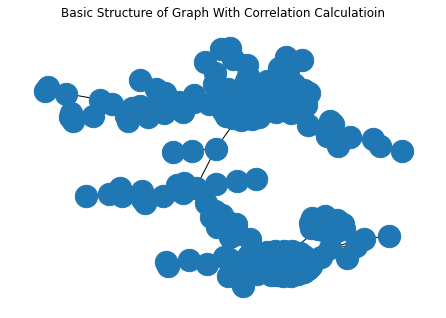

In [106]:
# and for correlation
show_graph_with_labels(graph2, make_label_dict(coin_names), 'Correlation')